In [1]:
import numpy as np
from obspy import read_events
from obspy import read_inventory
from obspy.clients.fdsn import Client
client_wm = Client("IRIS")
from obspy.clients.iris import Client  
from obspy.taup import TauPyModel
from obspy import Stream, Trace
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from obspy.geodetics import locations2degrees,degrees2kilometers
from scipy import signal
plt.rc('font', size=10) 
%matplotlib widget
import datetime
from obspy.signal.trigger import recursive_sta_lta,plot_trigger,coincidence_trigger
import pandas as pd
from matplotlib.dates import date2num
from obspy.imaging.util import (_set_xaxis_obspy_dates, _id_key, _timestring)
from matplotlib.ticker import MaxNLocator, ScalarFormatter

In [2]:
start_time=UTCDateTime(2020,9,1,0,0,0)
end_time=UTCDateTime(2020,9,10,0,0,0)
st_10day = client_wm.get_waveforms("AK", "SCRK", "*", "BHZ", start_time, end_time)
st_10day2=st_10day.copy()
st_10day2.merge(method=0,fill_value=0)

1 Trace(s) in Stream:
AK.SCRK..BHZ | 2020-09-01T00:00:00.008400Z - 2020-09-09T23:59:59.988400Z | 50.0 Hz, 38880000 samples

In [3]:
st_10day.write("SCRK_sep10Z.mseed", format="MSEED")  
# from obspy import read 
# SCRK_sep10Z= read("*.mseed") 

In [7]:
#trc=st_10day[0].detrend().filter('bandpass', freqmin=0.5,freqmax=25)

trc=st_10day2[0].detrend().filter('bandpass', freqmin=0.5,freqmax=25)
df = trc.stats.sampling_rate
npts = trc.stats.npts
t = np.arange(npts, dtype=np.float32) / df

/Users/yuantian/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


In [8]:
trace=trc.slice(starttime=start_time+470000,endtime=start_time+570000)

In [9]:
def threshold_trigger(th,record_time,trace):
    record_number=record_time*trace.stats.sampling_rate
    abs_st_data=np.abs(trace.data)
    ind_th=[]
    recording=False
    for i,abs_st in enumerate(abs_st_data):
        if abs_st>th and recording is False:
            ind_th.append(i)
            recording=True
        if ind_th!=[] and (i-ind_th[-1])>record_number:
            recording=False
    return len(ind_th),ind_th



def event_associate(pre_time,after_time,cat_arl_t,t,ind_th,cat_arl_i):
    n_recorded=0
    index_triggered=[]
    index_cat=[]
    for i in ind_th:
        for j,cat_t in enumerate(cat_arl_t):
            if cat_t>t[i]-pre_time and cat_t<t[i]+after_time:
                n_recorded=n_recorded+1
                index_triggered.append(cat_arl_i[j])
                index_cat.append(j)
                break
    return n_recorded,index_triggered,index_cat
def threshold_trigger_w_avg(th_fold,record_time,trace,window_len):
    record_number=record_time*trace.stats.sampling_rate
    abs_st_data=np.abs(trace.data)
    ind_th=[]
    recording=False
    rtt=0
    cm_sum=0
    ltavg=np.sum(abs_st_data[0:window_len])/window_len
    for i,abs_st in enumerate(abs_st_data):
        rtt=rtt+1
        if rtt>window_len:
            rtt=0
            ltavg=cm_sum/window_len
            #print(ltavg)
            cm_sum=abs_st
        cm_sum=cm_sum+abs_st
        if abs_st>th_fold*ltavg and recording is False:
            ind_th.append(i)
            recording=True
        if ind_th!=[] and (i-ind_th[-1])>record_number:
            recording=False
    return len(ind_th),ind_th

In [10]:
th=120
record_time=10*60 
th_fold=20
window_len=50*60*2
n,ind_th=threshold_trigger(th,record_time,trace)
n,ind_th2=threshold_trigger_w_avg(th_fold,record_time,trace,window_len)

In [11]:
fig2 = plt.figure(figsize=(8, 4))
SECONDS_PER_DAY=3600*24
x_values = ((trace.times() / SECONDS_PER_DAY) +date2num(trace.stats.starttime.datetime))
ax = fig2.add_subplot(211)
_set_xaxis_obspy_dates(ax)
plt.plot(x_values,trace.data)
ii,jj =ax.get_ylim()

plt.setp(ax.get_xticklabels())
plt.ylabel('amplitude (nm/s)')
for i in ind_th:
    ax.vlines(x_values[i], ii,jj, color='r', lw=2)

ax2 = fig2.add_subplot(212)
_set_xaxis_obspy_dates(ax2)
plt.plot(x_values,trace.data)
ii,jj =ax2.get_ylim()

plt.setp(ax2.get_xticklabels())
plt.ylabel('amplitude (nm/s)')
for i in ind_th2:
    ax2.vlines(x_values[i], ii,jj, color='r', lw=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/yuantian/anaconda3/envs/obspy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  color or c: color
  contains: callable
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font_properties: `.font_manager.FontProperties`
  fontsize or size: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or w

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

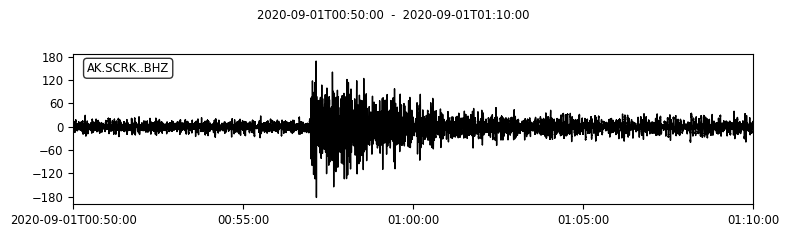

In [12]:
trc.plot(starttime=start_time+3000,endtime=start_time+4200)